In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install plotly
import plotly.graph_objects as go
def display_training_curves(training, validation, yaxis):
    ylabel = "{}".format(yaxis)
    title = "{} vs. Epochs".format(yaxis)
        
    fig = go.Figure()
        
    fig.add_trace(
        go.Scatter(x=np.arange(1, epochs+1), mode='lines+markers', y=training, marker=dict(color="dodgerblue"),
               name="Train"))
    
    fig.add_trace(
        go.Scatter(x=np.arange(1, epochs+1), mode='lines+markers', y=validation, marker=dict(color="darkorange"),
               name="Val"))
    
    fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
    fig.show()

In [5]:
# Set the path 
main_folder = "AugmentedSet"

In [6]:
# Set the desired ratio for train and test
train_ratio = 0.8  # 80% for training, 20% for testing

# Create dictionaries to store train and test file paths
train_files = {}
test_files = {}

random.seed(42)

In [7]:
# Iterate over the class folders
for class_folder in os.listdir(main_folder):
    class_path = os.path.join(main_folder, class_folder) 
    images = os.listdir(class_path) #A list containing images names for each class
    
    # Shuffle the images randomly
    random.seed(42)    
    random.shuffle(images)
    
    # Determine the split index based on the train ratio
    split_index = int(len(images) * train_ratio)
    
    # Assign images to train and test dictionaries
    train_files[class_folder] = images[:split_index] #Dictionary containing className: List of images
    test_files[class_folder] = images[split_index:]

In [8]:
# Define image dimensions and number of classes
image_width, image_height = 224, 224
num_classes = len(train_files)
print(num_classes)

4


In [9]:
# Create empty arrays to store the image data and labels
train_data = []
train_labels = []
test_data = []
test_labels = []

# Load and preprocess train set images
for class_folder, images in train_files.items():
    for image in images:
        image_path = os.path.join(main_folder, class_folder, image)
        img = load_img(image_path, target_size=(image_width, image_height))
        img_array = img_to_array(img)
        train_data.append(img_array)
        train_labels.append(class_folder)

# Load and preprocess test set images
for class_folder, images in test_files.items():
    for image in images:
        image_path = os.path.join(main_folder, class_folder, image)
        img = load_img(image_path, target_size=(image_width, image_height))
        img_array = img_to_array(img)
        test_data.append(img_array)
        test_labels.append(class_folder)

# Convert the data and labels to NumPy arrays
train_data = np.array(train_data)
test_data = np.array(test_data)

C:\Users\Gayan\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [10]:
# Create a dictionary to map class folder names to integer labels
class_label_map = {class_folder: i for i, class_folder in enumerate(train_files.keys())}

# Convert the train and test labels to integer labels
train_labels = np.array([class_label_map[label] for label in train_labels]) 
test_labels = np.array([class_label_map[label] for label in test_labels])


# Convert class labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [11]:
from tensorflow.keras.applications import ResNet50, MobileNetV3Large, MobileNetV3Small
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

# Freeze the pre-trained layers so they are not updated during training
for layer in resnet.layers:
    layer.trainable = False

In [12]:
model = tf.keras.backend.clear_session()
# Create a new model by adding the ResNet model on top of your existing layers
model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 3

history = model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(test_data, test_labels))



Epoch 1/3
69/69 ━━━━━━━━━━━━━━━━━━━━ 275s 4s/step - accuracy: 0.8224 - loss: 1.9442 - val_accuracy: 0.9781 - val_loss: 0.2174
Epoch 2/3
69/69 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.9917 - loss: 0.0681 - val_accuracy: 0.9927 - val_loss: 0.0137
Epoch 3/3
69/69 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.9905 - loss: 0.0693 - val_accuracy: 0.9709 - val_loss: 0.4412


In [13]:
# Evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

18/18 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.9534 - loss: 1.0040
Test Loss: 0.44124525785446167
Test Accuracy: 0.9708561301231384


In [14]:
# Evaluate the model and get the predicted labels
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = np.argmax(test_labels, axis=1)

# Compute the confusion matrix
confusion = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels)

# Convert the confusion matrix to a NumPy array
confusion = confusion.numpy()

18/18 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step


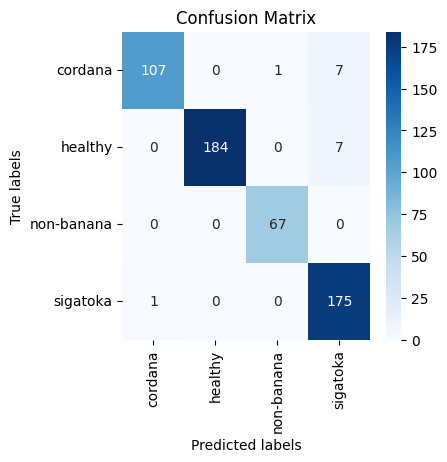

In [15]:
# Display the confusion matrix
plt.figure(figsize=(num_classes, num_classes))
ax = sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
# Modify the labels
new_x_labels = ['cordana', 'healthy', 'non-banana', 'sigatoka']
new_y_labels = ['cordana', 'healthy', 'non-banana', 'sigatoka']
# Set the modified labels
ax.set_xticklabels(new_x_labels, rotation=90)
ax.set_yticklabels(new_y_labels, rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
model.save('my_model1.h5')